# Symbolic Knowledge Injection
## Constraining a Neural Network with Symbolic Knowledge during Training

Importing the necessary libraries...

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import platform
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from data import PATH as DATA_PATH

Some utility constants

In [2]:
TRAINING_DATASET = "poker-hand-training-true.data"
TESTING_DATASET = "poker-hand-testing.data"
map_class_to_label = {
    0: "High Card",
    1: "One Pair",
    2: "Two Pair",
    3: "Three of a Kind",
    4: "Straight",
    5: "Flush",
    6: "Full House",
    7: "Four of a Kind",
    8: "Straight Flush",
    9: "Royal Flush"
}
FEATURE_NUMBER = 10
CLASS_NUMBER = 10
HIDDEN_SIZE = 64
EPOCHES = 100
BATCH_SIZE = 32
PYTORCH_SEED = 0
NUMPY_SEED = 0
RANDOM_SEED = 0


### Reproducibility
Set the random seeds for reproducibility.

In [3]:
torch.manual_seed(PYTORCH_SEED)
np.random.seed(NUMPY_SEED)
random.seed(RANDOM_SEED)

### Device selection

In [4]:
if platform.processor() == 'arm' or 'Apple' in platform.platform():
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
device = "cpu"
print(f"Using device: {device}")

Using device: cpu


### Dataset

This is the Poker Hand dataset from the UCI Machine Learning Repository. It contains 10 features representing the ranks and suits of 5 cards, and a label indicating the type of poker hand. In total there are 10 classes, each representing a different poker hand type. For the training set there are 25,010 samples, and for the test set 1,000,000 samples.

In [5]:
# Download the dataset if they are not already present
if not os.path.exists(os.path.join(DATA_PATH, TRAINING_DATASET)):
    print("Downloading training dataset...")
    os.system(f"wget https://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-training-true.data -P {DATA_PATH}")
if not os.path.exists(os.path.join(DATA_PATH, TESTING_DATASET)):
    print("Downloading testing dataset...")
    os.system(f"wget https://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-testing.data -P {DATA_PATH}")

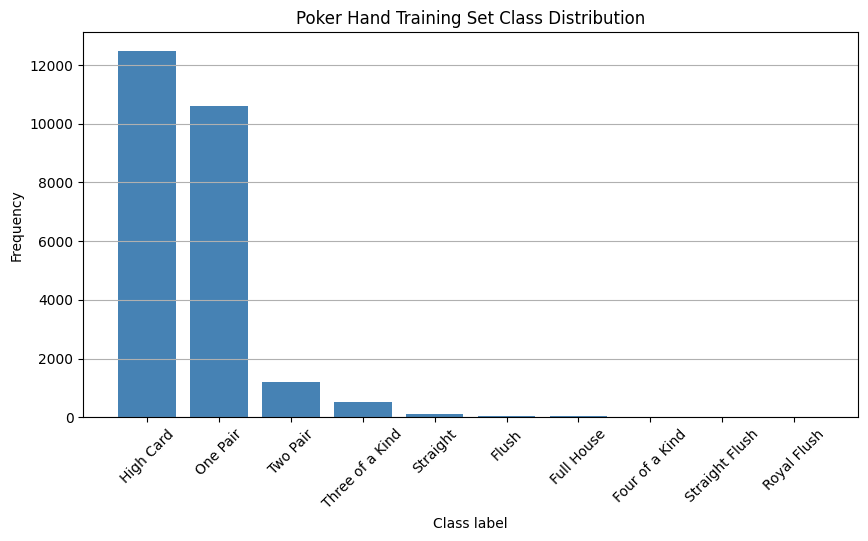

Training set statistics:
Class High Card: 12493 samples
Class One Pair: 10599 samples
Class Two Pair: 1206 samples
Class Three of a Kind: 513 samples
Class Straight: 93 samples
Class Flush: 54 samples
Class Full House: 36 samples
Class Four of a Kind: 6 samples
Class Straight Flush: 5 samples
Class Royal Flush: 5 samples


In [6]:
# Load the datasets
train_data = pd.read_csv(str (os.path.join(DATA_PATH, TRAINING_DATASET)), header=None)
test_data = pd.read_csv(str (os.path.join(DATA_PATH, TESTING_DATASET)), header=None)
cols = [f"card{i}_{attr}" for i in range(1, 6) for attr in ("suit", "rank")] + ["label"]
train_data.columns = cols
test_data.columns = cols

X_train = train_data.drop(columns=["label"]).values
y_train = train_data["label"].values
X_test = test_data.drop(columns=["label"]).values
y_test = test_data["label"].values

# Show class distribution
labels, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 5))
plt.bar(labels, counts, color='steelblue')
plt.xlabel("Class label")
plt.ylabel("Frequency")
plt.title("Poker Hand Training Set Class Distribution")
plt.xticks(ticks=labels, labels=[map_class_to_label[label] for label in labels], rotation=45)
plt.grid(axis='y')
plt.show()

print("Training set statistics:")
for label, count in zip(labels, counts):
    print(f"Class {map_class_to_label[label]}: {count} samples")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=BATCH_SIZE)

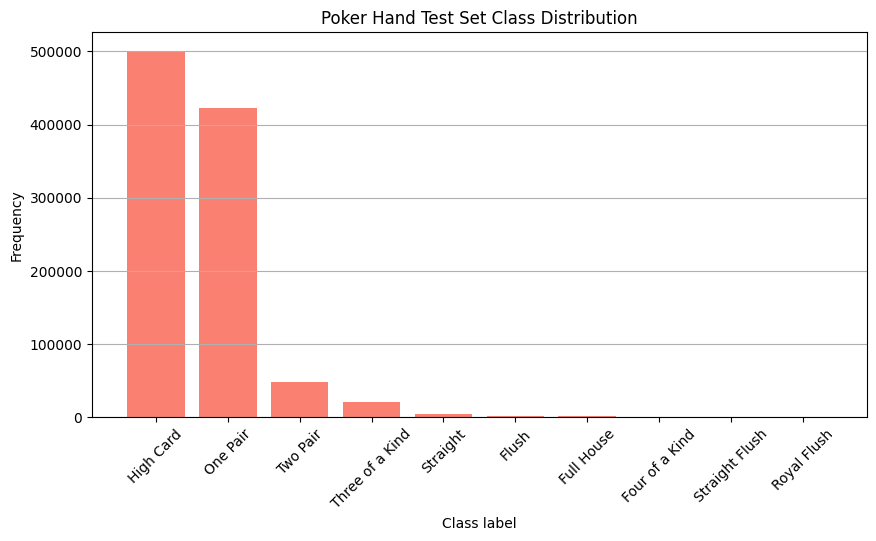

Test set statistics:
Class High Card: 501209 samples
Class One Pair: 422498 samples
Class Two Pair: 47622 samples
Class Three of a Kind: 21121 samples
Class Straight: 3885 samples
Class Flush: 1996 samples
Class Full House: 1424 samples
Class Four of a Kind: 230 samples
Class Straight Flush: 12 samples
Class Royal Flush: 3 samples


In [7]:
# Test set statistics

labels_test, counts_test = np.unique(y_test, return_counts=True)
plt.figure(figsize=(10, 5))
plt.bar(labels_test, counts_test, color='salmon')
plt.xlabel("Class label")
plt.ylabel("Frequency")
plt.title("Poker Hand Test Set Class Distribution")
plt.xticks(ticks=labels_test, labels=[map_class_to_label[label] for label in labels_test], rotation=45)
plt.grid(axis='y')
plt.show()

print("Test set statistics:")
for label, count in zip(labels_test, counts_test):
    print(f"Class {map_class_to_label[label]}: {count} samples")

### Neural Network Model

In [8]:
class PokerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(FEATURE_NUMBER, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, CLASS_NUMBER)
        )

    def forward(self, x):
        return self.model(x)


### Knowledge Injection

We define a symbolic rule that penalizes the model if it predicts a "Two Pair" hand when the input does not satisfy the conditions for a two pair hand. The rule checks if there are exactly two pairs of ranks in the input data.

In [9]:
def count_occurrences(rank_tensor, count_value):
    B = rank_tensor.size(0)
    counts = torch.zeros(B, device=rank_tensor.device)
    for i in range(B):
        unique, unique_counts = torch.unique(rank_tensor[i], return_counts=True)
        counts[i] = (unique_counts == count_value).sum()
    return counts

def rule_high_card(x_batch_orig, pred_logits):
    ranks = x_batch_orig[:, 1::2].int()  # Extract ranks from the input
    num_pairs = count_occurrences(ranks, 2)  # Count occurrences of pairs
    is_high_card = (num_pairs == 0)  # Check if there are no pairs
    prob_high_card = torch.softmax(pred_logits, dim=1)[:, 0]  # Probability of "High Card"
    penalty = ((1 - prob_high_card) ** 2) * is_high_card.float()  # Calculate penalty
    return penalty.mean()

def rule_one_pair(x_batch_orig, pred_logits):
    ranks = x_batch_orig[:, 1::2].int()  # Extract ranks from the input
    num_pairs = count_occurrences(ranks, 2)  # Count occurrences of pairs
    is_one_pair = (num_pairs == 1)  # Check if there is exactly one pair
    prob_one_pair = torch.softmax(pred_logits, dim=1)[:, 1]  # Probability of "One Pair"
    penalty = ((1 - prob_one_pair) ** 2) * is_one_pair.float()  # Calculate penalty
    return penalty.mean()

def rule_two_pair(x_batch_orig, pred_logits):
    ranks = x_batch_orig[:, 1::2].int()
    num_pairs = count_occurrences(ranks, 2)
    is_two_pair = (num_pairs == 2)
    prob_two_pair = torch.softmax(pred_logits, dim=1)[:, 2]
    penalty = ((1 - prob_two_pair) ** 2) * is_two_pair.float()
    return penalty.mean()

def rule_three_of_a_kind(x_batch_orig, pred_logits):
    ranks = x_batch_orig[:, 1::2].int()
    num_tris = count_occurrences(ranks, 3)
    is_three_kind = (num_tris == 1)
    prob_three_kind = torch.softmax(pred_logits, dim=1)[:, 3]
    penalty = ((1 - prob_three_kind) ** 2) * is_three_kind.float()
    return penalty.mean()

def is_straight(ranks):
    if ranks.dim() == 1:
        ranks = ranks.unsqueeze(0)  # Shape (1, 5)

    sorted_ranks, _ = torch.sort(ranks, dim=1)
    diff = sorted_ranks[:, 1:] - sorted_ranks[:, :-1]
    normal_straight = (diff == 1).all(dim=1) 

    low_ace = sorted_ranks.clone()
    low_ace[low_ace == 14] = 1
    low_ace_sorted, _ = torch.sort(low_ace, dim=1)
    diff_low_ace = low_ace_sorted[:, 1:] - low_ace_sorted[:, :-1]
    low_ace_straight = (diff_low_ace == 1).all(dim=1)

    return normal_straight | low_ace_straight

def rule_straight(x_batch_orig, pred_logits):
    ranks = x_batch_orig[:, 1::2].int()
    is_straight_hand = is_straight(ranks)
    prob_straight = torch.softmax(pred_logits, dim=1)[:, 4]
    penalty = ((1 - prob_straight) ** 2) * is_straight_hand.float()
    return penalty.mean()

def rule_flush(x_batch_orig, pred_logits):
    suits = x_batch_orig[:, ::2].int()  # Extract suits from the input
    B = suits.size(0)
    is_flush = torch.zeros(B, device=suits.device, dtype=torch.bool)

    for i in range(B):
        unique_suits, counts = torch.unique(suits[i], return_counts=True)
        if (counts == 5).any():  # Check if any suit appears 5 times
            is_flush[i] = True

    prob_flush = torch.softmax(pred_logits, dim=1)[:, 5]  # Probability of "Flush"
    penalty = ((1 - prob_flush) ** 2) * is_flush.float()  # Calculate penalty
    return penalty.mean()

def rule_full_house(x_batch_orig, pred_logits):
    ranks = x_batch_orig[:, 1::2].int()  # Extract ranks from the input
    num_pairs = count_occurrences(ranks, 2)  # Count occurrences of pairs
    num_tris = count_occurrences(ranks, 3)  # Count occurrences of three of a kind
    is_full_house = (num_pairs == 1) & (num_tris == 1)  # Check if there is one pair and one three of a kind
    prob_full_house = torch.softmax(pred_logits, dim=1)[:, 6]  # Probability of "Full House"
    penalty = ((1 - prob_full_house) ** 2) * is_full_house.float()  # Calculate penalty
    return penalty.mean()

def rule_four_of_a_kind(x_batch_orig, pred_logits):
    ranks = x_batch_orig[:, 1::2].int()  # Extract ranks from the input
    num_quads = count_occurrences(ranks, 4)  # Count occurrences of four of a kind
    is_four_kind = (num_quads == 1)  # Check if there is exactly one four of a kind
    prob_four_kind = torch.softmax(pred_logits, dim=1)[:, 7]  # Probability of "Four of a Kind"
    penalty = ((1 - prob_four_kind) ** 2) * is_four_kind.float()  # Calculate penalty
    return penalty.mean()

def rule_straight_flush(x_batch_orig, pred_logits):
    suits = x_batch_orig[:, ::2].int()  # Extract suits from the input
    ranks = x_batch_orig[:, 1::2].int()  # Extract ranks from the input

    B = suits.size(0)
    is_straight_flush = torch.zeros(B, device=suits.device, dtype=torch.bool)

    for i in range(B):
        unique_suits, counts = torch.unique(suits[i], return_counts=True)
        if (counts == 5).any():  # Check if any suit appears 5 times
            if is_straight(ranks[i]):
                is_straight_flush[i] = True

    prob_straight_flush = torch.softmax(pred_logits, dim=1)[:, 8]  # Probability of "Straight Flush"
    penalty = ((1 - prob_straight_flush) ** 2) * is_straight_flush.float()  # Calculate penalty
    return penalty.mean()

def rule_royal_flush(x_batch_orig, pred_logits):
    suits = x_batch_orig[:, ::2].int()  # Extract suits from the input
    ranks = x_batch_orig[:, 1::2].int()  # Extract ranks from the input

    B = suits.size(0)
    is_royal_flush = torch.zeros(B, device=suits.device, dtype=torch.bool)

    for i in range(B):
        unique_suits, counts = torch.unique(suits[i], return_counts=True)
        if (counts == 5).any():  # Check if any suit appears 5 times
            if is_straight(ranks[i]) and (torch.tensor([10, 11, 12, 13, 14], device=ranks.device) == ranks[i]).all():
                is_royal_flush[i] = True

    prob_royal_flush = torch.softmax(pred_logits, dim=1)[:, 9]  # Probability of "Royal Flush"
    penalty = ((1 - prob_royal_flush) ** 2) * is_royal_flush.float()  # Calculate penalty
    return penalty.mean()

def symbolic_loss(x_batch_orig, pred_logits):
    loss = (
        rule_high_card(x_batch_orig, pred_logits) +
        rule_one_pair(x_batch_orig, pred_logits) +
        rule_two_pair(x_batch_orig, pred_logits) +
        rule_three_of_a_kind(x_batch_orig, pred_logits) +
        rule_straight(x_batch_orig, pred_logits) +
        rule_flush(x_batch_orig, pred_logits) +
        rule_full_house(x_batch_orig, pred_logits) +
        rule_four_of_a_kind(x_batch_orig, pred_logits) +
        rule_straight_flush(x_batch_orig, pred_logits) +
        rule_royal_flush(x_batch_orig, pred_logits)
    )
    return loss

### Training

In [10]:
# Train the model with or without symbolic knowledge injection
# Combine standard loss and symbolic loss via lambda ∈ [0, 1]
def train_model(use_rules=False, lambda_reg=.5) -> tuple[nn.Module, list[float]]:
    assert 0.0 <= lambda_reg <= 1.0, "lambda_reg must be in [0, 1]"

    model = PokerNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    loss_history = []

    # Rebuild the DataLoader to include both scaled and original input
    X_train_tensor_orig = torch.tensor(X_train, dtype=torch.float32).to(device)  # original unscaled input
    train_loader_full = DataLoader(
        TensorDataset(X_train_tensor, y_train_tensor, X_train_tensor_orig),
        batch_size=BATCH_SIZE, shuffle=True
    )

    for epoch in range(EPOCHES):
        model.train()
        total_loss = 0
        for xb_scaled, yb, xb_orig in train_loader_full:
            xb_scaled, yb, xb_orig = xb_scaled.to(device), yb.to(device), xb_orig.to(device)
            optimizer.zero_grad()
            preds = model(xb_scaled)
            ce_loss = criterion(preds, yb)

            if use_rules:
                reg_loss = symbolic_loss(xb_orig, preds)  # use unscaled input for rules
                # Combine the two losses via convex combination
                loss = abs((1 - lambda_reg) * ce_loss + lambda_reg * reg_loss)
            else:
                loss = ce_loss

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader_full)
        loss_history.append(avg_loss)
        if (epoch + 1) % 10 == 0 or epoch == EPOCHES - 1:
            print(f"Epoch {epoch+1}: loss = {avg_loss:.4f}")

    return model, loss_history


### Evaluate

In [11]:
def evaluate(model):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            y_true.extend(yb.to("cpu").numpy())
            y_pred.extend(torch.argmax(preds, dim=1).to("cpu").numpy())
    report = classification_report(
        y_true, y_pred, target_names=[map_class_to_label[i] for i in range(CLASS_NUMBER)],
        digits=4, output_dict=True, zero_division=0
    )
    return report

### Comparison

In [ ]:
#print("--- Training without Symbolic Knowledge ---")
#model_base, history1 = train_model(use_rules=False)
#report1 = evaluate(model_base)

print("\n--- Training with Symbolic Knowledge ---")
model_symbolic, history2 = train_model(use_rules=True, lambda_reg=1)
report2 = evaluate(model_symbolic)


--- Training with Symbolic Knowledge ---
Epoch 10: loss = 0.3031
Epoch 20: loss = 0.2980


### Loss history

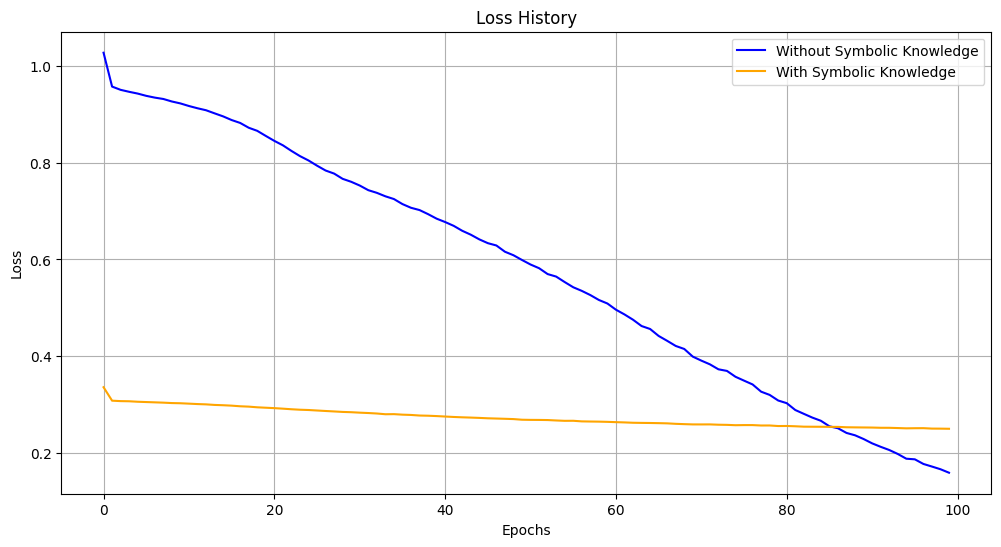

In [14]:
def plot_loss_history(loss_history1, loss_history2):
    plt.figure(figsize=(12, 6))
    plt.plot(loss_history1, label='Without Symbolic Knowledge', color='blue')
    plt.plot(loss_history2, label='With Symbolic Knowledge', color='orange')
    plt.title('Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
    
plot_loss_history(history1, history2)
    

### Classification Reports

In [15]:
print("--- Classification Report without Symbolic Knowledge ---")
print(pd.DataFrame(report1).transpose())
print("\n--- Classification Report with Symbolic Knowledge ---")
print(pd.DataFrame(report2).transpose())

--- Classification Report without Symbolic Knowledge ---
                 precision    recall  f1-score         support
High Card         0.966340  0.975455  0.970876   501209.000000
One Pair          0.933666  0.964916  0.949034   422498.000000
Two Pair          0.770882  0.619756  0.687107    47622.000000
Three of a Kind   0.778513  0.623739  0.692585    21121.000000
Straight          0.508772  0.029858  0.056407     3885.000000
Flush             0.990120  0.702906  0.822151     1996.000000
Full House        0.563025  0.094101  0.161252     1424.000000
Four of a Kind    0.011561  0.008696  0.009926      230.000000
Straight Flush    0.055556  0.166667  0.083333       12.000000
Royal Flush       0.008065  0.333333  0.015748        3.000000
accuracy          0.940928  0.940928  0.940928        0.940928
macro avg         0.558650  0.451943  0.444842  1000000.000000
weighted avg      0.936722  0.940928  0.937019  1000000.000000

--- Classification Report with Symbolic Knowledge ---
      

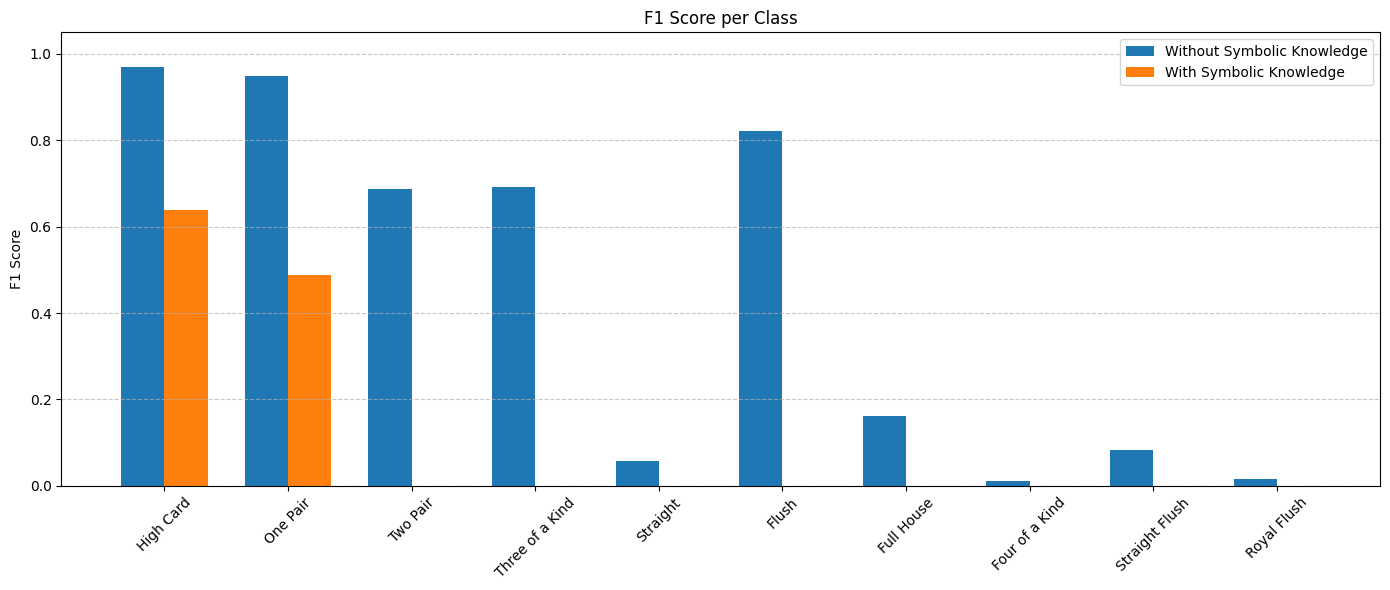

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def plot_classification_report(report1, report2):
    labels = list(map_class_to_label.values())
    x = np.arange(len(labels))  # Indici per le classi

    f1_scores1 = [report1[label]['f1-score'] for label in labels]
    f1_scores2 = [report2[label]['f1-score'] for label in labels]

    width = 0.35  # Larghezza delle barre

    plt.figure(figsize=(14, 6))
    plt.bar(x - width/2, f1_scores1, width, label='Without Symbolic Knowledge')
    plt.bar(x + width/2, f1_scores2, width, label='With Symbolic Knowledge')

    plt.xticks(x, labels, rotation=45)
    plt.ylabel('F1 Score')
    plt.title('F1 Score per Class')
    plt.legend()
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_classification_report(report1, report2)